# Import libraries

In [19]:
import time
from pathlib import Path
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

# conditional random fields
import ace_sklearn_crfsuite
from ace_sklearn_crfsuite import metrics

# self-made
import src.analysis as analysis
import src.anomaly_model as anomaly_model
import src.utils as utils
import src.sensor_model as sensor_model

working_path = Path().resolve()
layout_database_path = working_path / "layout_data"


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

def fall_feature_sliding(mat, time_step, window_len, nrt_type = "instantaneous"):
    """
    Calculate features for fall detection.
    The feature includes;
    1: non response time of all sensors at the present time
    2: maximum height of the edge of the non response time sequence in the left / right part of the window.

    Parameters
    ----------
    mat : nummpy.ndarray of bool
        Raw sensor data matrix.
        mat[i][j] = j-th sensor state at i-th time.
    time_step : float
        Time step length [seconds] of mat = mat[1][0] - mat[0][0].
    window_len : int
        Length of window.
        window_len is the number of columns in mat.
        window_len must be an odd number.
    mode : int
        "instantaneous" : instantaneous non response time
        "sum" : sum in the window
        "max" : max in the window
    
    Returns
    -------
    feature : numpy.ndarray
        (number of time, dimension of feature).
        feature[t] = feature vector of the t-th time.
        feature.shape[0] == mat.shape[0].
        Let w be a (window_len - 1)/2.
        feature.shape[i] is a vector made from mat[i-w/2:i+w/2+1] for any w/2 <= i <mat.shape[0]-w/2
        feature.shape[i] is a vector made from mat[0:i+w/2+1] for any i < w/2.
        feature.shape[i] is a vector made from mat[i-w/2:mat.shape[0]] for any i >= mat.shape[0]-w/2.
        sensor_num_dic saves the realtion between index of sensors and index of features.
    """
    feature = np.zeros((mat.shape[0], mat.shape[1]), dtype = np.int32)
    for i, item in enumerate(gen_fall_feature_sliding(mat, time_step, window_len, nrt_type)):
        feature[i] = item
    return feature

def gen_fall_feature_sliding(mat, time_step, window_len, nrt_type = "instantaneous"):
    """
    Generator.
    Calculate features for fall detection.
    The feature includes;
    1: non response time of all sensors at the present time
    2: maximum height of the edge of the non response time sequence in the left / right part of the window.

    Parameters
    ----------
    mat : nummpy.ndarray of bool
        Raw sensor data matrix.
        mat[i][j] = j-th sensor state at i-th time.
    time_step : float
        Time step length [seconds] of mat = mat[1][0] - mat[0][0].
    window_len : int
        Length of window.
        window_len is the number of columns in mat.
        window_len must be an odd number.
    mode : int
        "instantaneous" : instantaneous non response time
        "sum" : sum in the window
        "max" : max in the window
    
    Yields
    ------
    feature : numpy.ndarray
        (dimension of feature, ).
    """

    # Initialize the output array
    sensor_num = mat.shape[1]
    last_fired_time = -1
    last_fired_sensors = np.ones(sensor_num, dtype = bool)

    for (i, sd) in enumerate(mat):
        utils.print_progress_bar(mat.shape[0] - 1, i, "Extract fall features.", step = 10000)
        if np.any(sd):
            last_fired_sensors = sd
            last_fired_time = i
            yield 0 * last_fired_sensors
        else:
            yield (i - last_fired_time) * time_step * last_fired_sensors


def extract_data_with_fall_feature_sliding(path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000):
    if data_range not in ["full", "around_anomalies"]:
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_1")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_raw_1")    # !!!!!!!!!!!!!!!!!!!!
    AL = utils.pickle_load(path / "experiment", f"AL_mat_raw_1")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):  # !!!!!!!!!!!!!!!!!
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    anomaly_index = 4
    AL = AL[:, anomaly_index]
    
    # extract features of non response time
    if data_range == "full":
        X = fall_feature_sliding(SD, time_step=time_step, window_len=window_len, nrt_type=nrt_type)
        return X, AL, motion_sensor_indexes
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        X = np.empty((0, len(motion_sensor_indexes)))
        y = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            feature = fall_feature_sliding(SD[start:end], time_step=time_step, window_len=window_len, nrt_type=nrt_type)
            X = np.vstack((X, feature))
            for i in range(start, end):
                y.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return X, np.array(y), motion_sensor_indexes
    
    
def online_detection_test(classifier, path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000,
                          buffer_size = 3600):
    """
    
    Returns
    -------
    (y_true, y_pred) : tuple of numpy.ndarray
    """

    def predict_with_buffer(classifier, SD, time_step, window_len, nrt_type, buffer_size=buffer_size):
        y_pred = np.zeros(SD.shape[0], dtype=bool)
        item_buffer = []
        buffer_indices = []

        for i, item in enumerate(gen_fall_feature_sliding(SD, time_step, window_len, nrt_type)):
            item_buffer.append(item.reshape(1, -1))
            buffer_indices.append(i)

            if len(item_buffer) >= buffer_size:
                buffer_array = np.vstack(item_buffer)
                y_pred_batch = classifier.predict(buffer_array)
                
                for index, pred in zip(buffer_indices, y_pred_batch):
                    y_pred[index] = pred
                
                item_buffer = []
                buffer_indices = []

        if item_buffer:
            buffer_array = np.vstack(item_buffer)
            y_pred_batch = classifier.predict(buffer_array)
            for index, pred in zip(buffer_indices, y_pred_batch):
                y_pred[index] = pred

        return y_pred
    
    
    if (data_range not in ["full", "around_anomalies"]) and not isinstance(data_range, tuple):
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_{time_step}")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_{data_type}_{time_step}")
    AL = utils.pickle_load(path / "experiment", f"AL_mat_{data_type}_{time_step}")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    anomaly_index = 4
    AL = AL[:, anomaly_index]

    # extract features of non response time
    if data_range == "full":
        return AL, predict_with_buffer(classifier, SD, time_step, window_len, nrt_type, buffer_size=3600)
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        y_true = []
        y_pred = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
                y_pred.append(classifier.predict(item.reshape(1, -1)))
            for i in range(start, end):
                y_true.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return y_true, y_pred
    elif isinstance(data_range, tuple):
        start, end = data_range[0], data_range[1]
        y_pred = np.zeros(end-start, dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
            y_pred[i] = classifier.predict(item.reshape(1, -1))
        return AL[start:end], y_pred


def online_detection_rule(path, data_type = "raw", time_step = 1, window_len = 121, nrt_type = "instantaneous", data_range = "full", half_len = 10000, second_threshold = 20):
    """
    
    Returns
    -------
    (y_true, y_pred) : tuple of numpy.ndarray
    """


    def classifier_rule(vec, valid_range):
        for i, v in enumerate(vec):
            if (i in valid_range) and v >= second_threshold:
                return True
        return False    
    
    if (data_range not in ["full", "around_anomalies"]) and not isinstance(data_range, tuple):
        raise ValueError("data_range is invalid value!")
    
    SD_model = utils.pickle_load(path, "SD_model")
    # SD = utils.pickle_load(path / "experiment", f"reduced_301_SD_mat_{data_type}_{time_step}")
    SD = utils.pickle_load(path / "experiment", f"SD_mat_{data_type}_{time_step}")
    AL = utils.pickle_load(path / "experiment", f"AL_mat_{data_type}_{time_step}")
    SD_names = utils.pickle_load(path / "experiment", "SD_names")

    # extract motion sensor data
    motion_sensor_indexes = []
    for i, s_i in enumerate(SD_names):
        if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):
            motion_sensor_indexes.append(i)
    SD = SD[:, motion_sensor_indexes]

    # extract fall labels
    anomaly_index = 4
    AL = AL[:, anomaly_index]

    valid_range = set(range(0, 22)) | {33, 34} 

    # extract features of non response time
    if data_range == "full":
        y_pred = np.zeros(SD.shape[0], dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD, time_step, window_len, nrt_type)):
            y_pred[i] = classifier_rule(item, valid_range)
        return AL, y_pred
    elif data_range == "around_anomalies":
        fall_indices = analysis.find_true_regions_in_ndarray(AL)
        y_true = []
        y_pred = []
        for r in fall_indices:
            start, end = r[0] - half_len, r[1] + half_len
            if (start < 0) or (SD.shape[0] < end):
                continue
            for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
                y_pred.append(classifier_rule(item, valid_range))
            for i in range(start, end):
                y_true.append(True in [r[0] <= i < r[1] for r in fall_indices])
        return y_true, y_pred
    elif isinstance(data_range, tuple):
        start, end = data_range[0], data_range[1]
        y_pred = np.zeros(end-start, dtype = bool)
        for i, item in enumerate(gen_fall_feature_sliding(SD[start:end], time_step, window_len, nrt_type)):
            y_pred[i] = classifier_rule(item, valid_range)
        return AL[start:end], y_pred

data_type = "raw"
time_step = 1
window_len = 121
# half_len = 5000
half_len = 30000
nrt_type = "instantaneous"
train_path = layout_database_path / "test_layout" / "fall_test_2"
test_path = layout_database_path / "test_layout" / "test_data_5"

In [18]:
# # training data

train_path = layout_database_path / "test_layout" / "fall_test_2"
X_train, y_train, motion_sensor_indexes  = extract_data_with_fall_feature_sliding(train_path, 
        data_type = data_type, time_step = time_step, window_len = window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len)
print("Training data is ready!")

# decision tree
decision_tree = DecisionTreeClassifier(min_samples_leaf=5)
decision_tree.fit(X_train, y_train)
print("Classifier is ready!")
utils.pickle_dump(test_path / "experiment", "decision_tree_new", decision_tree)

Training data is ready!
Classifier is ready!


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print("Classifier is ready!")
utils.pickle_dump(test_path / "experiment", "random_forest_new", rf)

In [20]:
second_threshold = 5
# dt = utils.pickle_dump(test_path / "experiment", "decision_tree_new", decision_tree)
y_test_rule, y_pred_rule = online_detection_rule(test_path,
        data_type = data_type, time_step = time_step, window_len=window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len,second_threshold=second_threshold)
utils.pickle_dump(test_path / "experiment", "y_test_rule_long_new", y_test_rule)
utils.pickle_dump(test_path / "experiment", "y_pred_rule_long_new", y_pred_rule)

In [ ]:
# test data
test_path = layout_database_path / "test_layout" / "test_data_5"

dt = utils.pickle_load(test_path / "experiment", "decision_tree_new")
y_test_dt, y_pred_dt = online_detection_test(dt, test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len)
utils.pickle_dump(test_path / "experiment", "y_test_dt_long_new", y_test_dt)
utils.pickle_dump(test_path / "experiment", "y_pred_dt_long_new", y_pred_dt)

In [ ]:
# test data
test_path = layout_database_path / "test_layout" / "test_data_5"

rf = utils.pickle_load(test_path / "experiment", "random_forest_new")
y_test_rf, y_pred_rf = online_detection_test(rf, test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = "full", half_len = half_len)
utils.pickle_dump(test_path / "experiment", "y_test_rf_long_new", y_test_rf)
utils.pickle_dump(test_path / "experiment", "y_pred_rf_long_new", y_pred_rf)

len(consecutive_length): 11980
less than 5 [sec.]: 1039


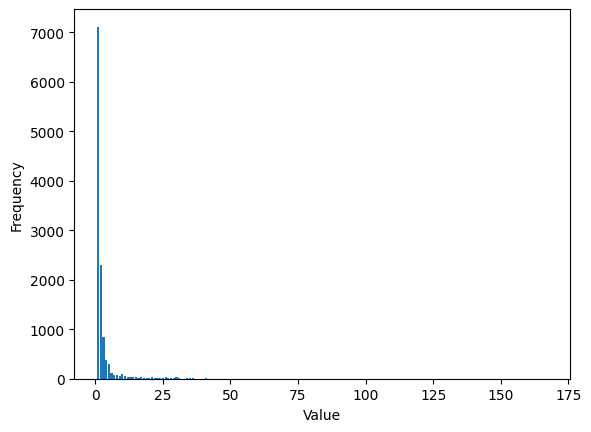

In [17]:
import matplotlib.pyplot as plt

true_regions = analysis.find_true_regions_in_ndarray(y_pred_dt_long)
consecutive_length = [r[1] - r[0] for r in true_regions]
print(f"len(consecutive_length): {len(consecutive_length)}")
seconds = 5
less_than_num = 0
for x in consecutive_length:
    if x > seconds:
        less_than_num += 1
print(f"less than {seconds} [sec.]: {less_than_num}")

sorted_one = sorted(consecutive_length)[:-30]
plt.hist(sorted_one, bins=range(min(sorted_one), max(sorted_one) + 2), align='left', rwidth=0.8)

# X軸に表示する値の設定
# plt.xticks(range(min(new), max(new) + 1))

# タイトルと軸ラベルの追加
plt.xlabel('Value')
plt.ylabel('Frequency')

# ヒストグラムの表示
plt.show()

In [2]:
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")
y_test_dt = utils.pickle_load(test_path / "experiment", "y_test_dt")
y_pred_dt = utils.pickle_load(test_path / "experiment", "y_pred_dt")

_max = 35
days = 9 * 12  * 30
x = list(range(1, _max))
recall_list = []
far_list = []
hpfa_list = []
for interval in range(1, _max):
    utils.print_progress_bar(_max - 1, interval, "", 1)
    recall = recall_score(np.array([all(y_test_dt[i:i+interval]) for i in range(0, len(y_test_dt), interval)]),
                          np.array([all(y_pred_dt[i:i+interval]) for i in range(0, len(y_pred_dt), interval)]))
    recall_list.append(recall)
    temp_test = np.array([all(y_test_dt_long[i:i+interval]) for i in range(0, len(y_test_dt_long), interval)])
    temp_pred = np.array([all(y_pred_dt_long[i:i+interval]) for i in range(0, len(y_pred_dt_long), interval)])
    false_alarm_rate = np.sum((temp_test == False) & (temp_pred == True)) / days
    far_list.append(false_alarm_rate)
    hour_per_false_alarm = 24 / false_alarm_rate
    hpfa_list.append(hour_per_false_alarm)

 34 / 34. Completed!


In [8]:
threshold = 20
print(recall_list[threshold - 1])
print(far_list[threshold - 1])
print(hpfa_list[threshold - 1])

0.7647058823529411
0.3132716049382716
76.61083743842364


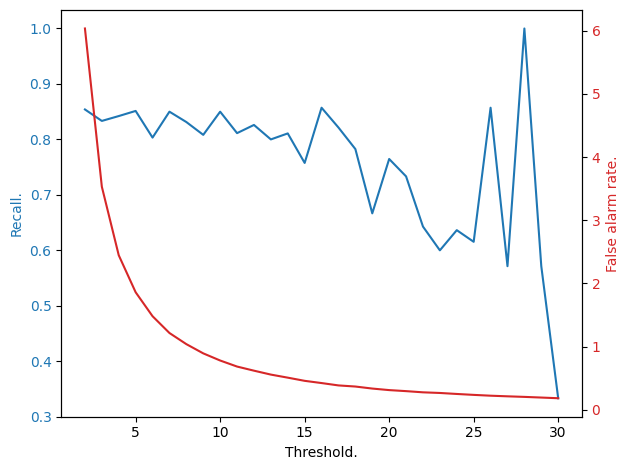

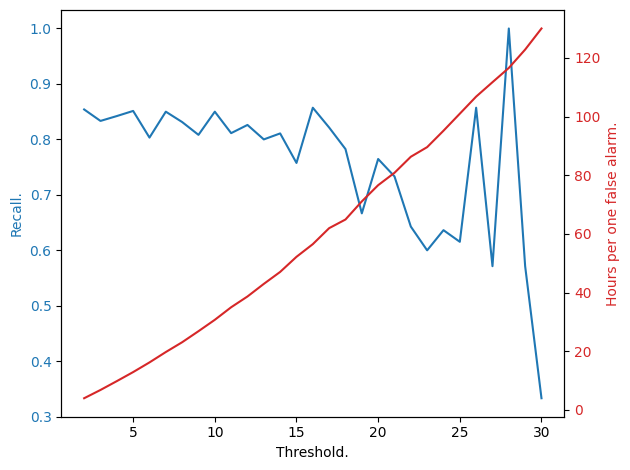

In [4]:
start_threshold = 1
end_threshold = 30
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Threshold.')
ax1.set_ylabel('Recall.', color=color)
ax1.plot(x[start_threshold:end_threshold], recall_list[start_threshold:end_threshold], color=color, label='Recall')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('False alarm rate.', color=color)
ax2.plot(x[start_threshold:end_threshold], far_list[start_threshold:end_threshold], color=color, label='False alarm rate.')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()
plt.close()


start_threshold = 1
end_threshold = 30
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.set_xlabel('Threshold.')
ax1.set_ylabel('Recall.', color=color)
ax1.plot(x[start_threshold:end_threshold], recall_list[start_threshold:end_threshold], color=color, label='Recall')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Hours per one false alarm.', color=color)
ax2.plot(x[start_threshold:end_threshold], hpfa_list[start_threshold:end_threshold], color=color, label='Hours per one false alarm.')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()
plt.close()

Number of walkings: 172996
Number of falling while walking: 26
Days of falling while walking: {128, 135, 1545, 910, 2067, 1687, 2338, 2860, 2481, 434, 1722, 2876, 3141, 2759, 464, 1490, 1107, 1495, 2139, 990, 2910, 3046, 2922, 2802, 3193, 2301}


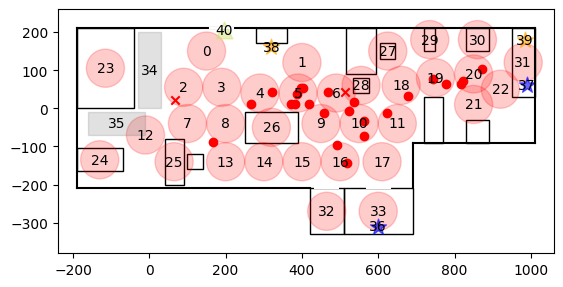

In [15]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt = utils.pickle_load(test_path / "experiment", "y_test_dt")
y_pred_dt = utils.pickle_load(test_path / "experiment", "y_pred_dt")

# Plot fall places
layout_path = layout_database_path / "test_layout"
WT = utils.pickle_load(test_path, "WT")
sensors = utils.pickle_load(test_path, "SD_model")
true_regions = analysis.find_true_regions_in_ndarray(y_test_dt)
fall_w_points = []
fall_w_days = set()
fall_detection_rate = []
fall_num = 0
for i, wt in enumerate(WT):
    if wt.fall_w:
        fall_w_points.append(wt.centers[wt.fall_w_index])
        fall_w_days.add(wt.timestamp[0].days)
        r = true_regions[fall_num]
        fall_detection_rate.append(np.sum(y_pred_dt[r[0]:r[1]]) / (r[1]-r[0]))
        fall_num += 1
print(f"Number of walkings: {len(WT)}")
print(f"Number of falling while walking: {len(fall_w_points)}")
print(f"Days of falling while walking: {fall_w_days}")
success_points = []
miss_points = []
for p, r in zip(fall_w_points, fall_detection_rate):
    if r >= 0.7:
        success_points.append(p)
    else:
        miss_points.append(p)
ax = utils.save_layout(test_path, layout_path, sensors=sensors,WT=[],
    show=False, color_map_name="Blues", filename="fall_points",dpi=400,return_ax=True, with_name_furniture_place=False)
ax.scatter([p[0] for p in success_points], [p[1] for p in success_points], marker="o", color="red")
ax.scatter([p[0] for p in miss_points], [p[1] for p in miss_points], marker="x", color="red")
# plt.savefig(test_path / "experiment" / "fall_DT_3", dpi = 400, bbox_inches="tight")
plt.show()

Number of walkings: 172996
Number of falling while walking: 26
Days of falling while walking: {128, 135, 1545, 910, 2067, 1687, 2338, 2860, 2481, 434, 1722, 2876, 3141, 2759, 464, 1490, 1107, 1495, 2139, 990, 2910, 3046, 2922, 2802, 3193, 2301}


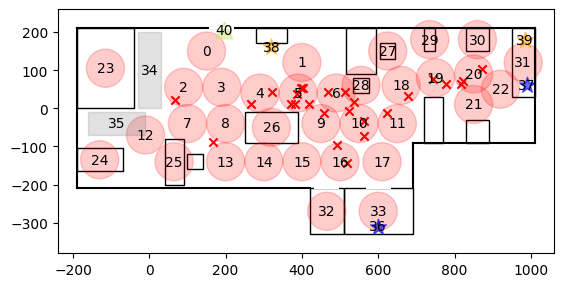

In [14]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_rule = utils.pickle_load(test_path / "experiment", "y_test_rule")
y_pred_rule = utils.pickle_load(test_path / "experiment", "y_pred_rule")

# Plot fall places
layout_path = layout_database_path / "test_layout"
WT = utils.pickle_load(test_path, "WT")
sensors = utils.pickle_load(test_path, "SD_model")
true_regions = analysis.find_true_regions_in_ndarray(y_test_rule)
fall_w_points = []
fall_w_days = set()
fall_detection_rate = []
fall_num = 0
for i, wt in enumerate(WT):
    if wt.fall_w:
        fall_w_points.append(wt.centers[wt.fall_w_index])
        fall_w_days.add(wt.timestamp[0].days)
        r = true_regions[fall_num]
        fall_detection_rate.append(np.sum(y_pred_rule[r[0]:r[1]]) / (r[1]-r[0]))
        fall_num += 1
print(f"Number of walkings: {len(WT)}")
print(f"Number of falling while walking: {len(fall_w_points)}")
print(f"Days of falling while walking: {fall_w_days}")
success_points = []
miss_points = []
for p, r in zip(fall_w_points, fall_detection_rate):
    if r >= 0.7:
        success_points.append(p)
    else:
        miss_points.append(p)
ax = utils.save_layout(test_path, layout_path, sensors=sensors,WT=[],
    show=False, color_map_name="Blues", filename="fall_points",dpi=400,return_ax=True, with_name_furniture_place=False)
ax.scatter([p[0] for p in success_points], [p[1] for p in success_points], marker="o", color="red")
ax.scatter([p[0] for p in miss_points], [p[1] for p in miss_points], marker="x", color="red")
# plt.savefig(test_path / "experiment" / "fall_DT_3", dpi = 400, bbox_inches="tight")
plt.show()

In [4]:
test_path = layout_database_path / "test_layout" / "test_data_5"
decision_tree = utils.pickle_load(test_path / "experiment", "decision_tree")

second_threshold = 5
y_test_rule, y_pred_rule = online_detection_rule(test_path,
        data_type = data_type, time_step = time_step, window_len=window_len, nrt_type = nrt_type, data_range = "around_anomalies", half_len = half_len,second_threshold=second_threshold)
print("Test error ------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule, y_pred_rule))
print("Classification report")
print(classification_report(y_test_rule, y_pred_rule))

Extract fall features. 60038 / 60038. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall features. 60023 / 60023. Completed!
Extract fall features. 60026 / 60026. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60032 / 60032. Completed!
Extract fall features. 60030 / 60030. Completed!
Extract fall features. 60036 / 60036. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60027 / 60027. Completed!
Extract fall features. 60037 / 60037. Completed!
Extract fall features. 60039 / 60039. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60035 / 60035. Completed!
Extract fall features. 60034 / 60034. Completed!
Extract fall features. 60029 / 60029. Completed!
Extract fall features. 60018 / 60018. Completed!
Extract fall features. 60028 / 60028. Completed!
Extract fall features. 60038 / 60038. Completed!
Extract fall features. 60021 / 60021. Completed!
Extract fall feature

In [6]:
end = 9*360*24*60*60
start = end - 3*30*24*60*60
y_test_rule_long, y_pred_rule_long = online_detection_rule(test_path,
        data_type = data_type, time_step=time_step, window_len=window_len, nrt_type = nrt_type, data_range = (start, end), half_len = half_len)

print("Test error Rule------------------------")
print("Confusion matrix:")
print(confusion_matrix(y_test_rule_long, y_pred_rule_long))
print("Classification report")
print(classification_report(y_test_rule_long, y_pred_rule_long))

Extract fall features. 7775999 / 7775999. Completed!
Test error Rule------------------------
Confusion matrix:
[[7775074     898]
 [     17      11]]
Classification report
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   7775972
        True       0.01      0.39      0.02        28

    accuracy                           1.00   7776000
   macro avg       0.51      0.70      0.51   7776000
weighted avg       1.00      1.00      1.00   7776000



# Another metrics

In [ ]:
test_path = layout_database_path / "test_layout" / "test_data_5"
decision_tree = utils.pickle_load(test_path / "experiment", "decision_tree")
y_test_rule_long = utils.pickle_load(test_path / "experiment", "y_test_rule_long")
y_pred_rule_long = utils.pickle_load(test_path / "experiment", "y_pred_rule_long")
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")
y_test_dt = utils.pickle_load(test_path / "experiment", "y_test_dt")
y_pred_dt = utils.pickle_load(test_path / "experiment", "y_pred_dt")

In [6]:
test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")
days = 9 * 360
threshold = 10
sensitivity, false_alarm, mean_alarm_length = analysis.original_metrics(y_test_dt_long, y_pred_dt_long, threshold = threshold)
false_alarm_rate = false_alarm / days
print(f"sensitivity: {sensitivity:.2f}, false_alarm_rate [num/day]: {false_alarm_rate:.2f}, "
      f"hours_per_false_alarm [hours/num]: {24 / false_alarm_rate:.2f}, mean_alarm_length: {mean_alarm_length:.2f}")

sensitivity: 0.92, false_alarm_rate [num/day]: 0.21, hours_per_false_alarm [hours/num]: 113.52, mean_alarm_length: 45.40


In [16]:
import matplotlib.pyplot as plt

test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")

threshold_max = 40
days = 9 * 360
use_fixed_alarm = False
alarm_length = 5 * 60
thresholds = list(range(1, threshold_max + 1))
sensitivity_list = []
false_alarm_rate_list = []
hours_per_false_alarm_list = []
mean_alarm_length_list = []
for th in thresholds:
    utils.print_progress_bar(threshold_max, th, "Calculating metrics.", 1)
    sensitivity, false_alarm, mean_alarm_length = analysis.original_metrics(y_test_dt_long, y_pred_dt_long, threshold = th,
                                                                            use_fixed_alarm = use_fixed_alarm, alarm_length = alarm_length)
    false_alarm_rate = false_alarm / days
    sensitivity_list.append(sensitivity)
    false_alarm_rate_list.append(false_alarm_rate)
    hours_per_false_alarm_list.append(24 / false_alarm_rate)
    mean_alarm_length_list.append(mean_alarm_length)

for (th, s, far, hpf, mal) in zip(thresholds, sensitivity_list, false_alarm_rate_list, hours_per_false_alarm_list, mean_alarm_length_list):
    print(f"threhold: {th}, sensitivity: {s:.2f}, false_alarm_rate [num/day]: {far:.2f}, "
          f"hours_per_false_alarm [hours/num]: {hpf:.2f}, mean_alarm_length: {mal:.2f}")

Calculating metrics. 40 / 40. Completed!
threhold: 1, sensitivity: 0.96, false_alarm_rate [num/day]: 3.05, hours_per_false_alarm [hours/num]: 7.88, mean_alarm_length: 6.11
threhold: 2, sensitivity: 0.96, false_alarm_rate [num/day]: 1.56, hours_per_false_alarm [hours/num]: 15.34, mean_alarm_length: 10.92
threhold: 3, sensitivity: 0.96, false_alarm_rate [num/day]: 0.90, hours_per_false_alarm [hours/num]: 26.59, mean_alarm_length: 17.41
threhold: 4, sensitivity: 0.96, false_alarm_rate [num/day]: 0.65, hours_per_false_alarm [hours/num]: 36.84, mean_alarm_length: 22.89
threhold: 5, sensitivity: 0.96, false_alarm_rate [num/day]: 0.52, hours_per_false_alarm [hours/num]: 45.88, mean_alarm_length: 27.46
threhold: 6, sensitivity: 0.96, false_alarm_rate [num/day]: 0.43, hours_per_false_alarm [hours/num]: 55.66, mean_alarm_length: 32.17
threhold: 7, sensitivity: 0.96, false_alarm_rate [num/day]: 0.39, hours_per_false_alarm [hours/num]: 61.67, mean_alarm_length: 34.94
threhold: 8, sensitivity: 0.96

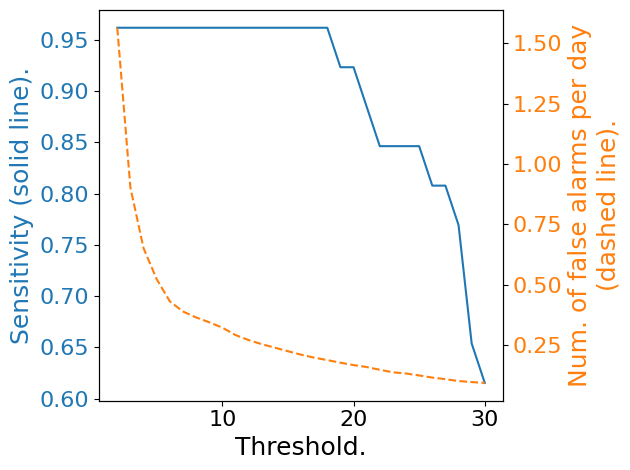

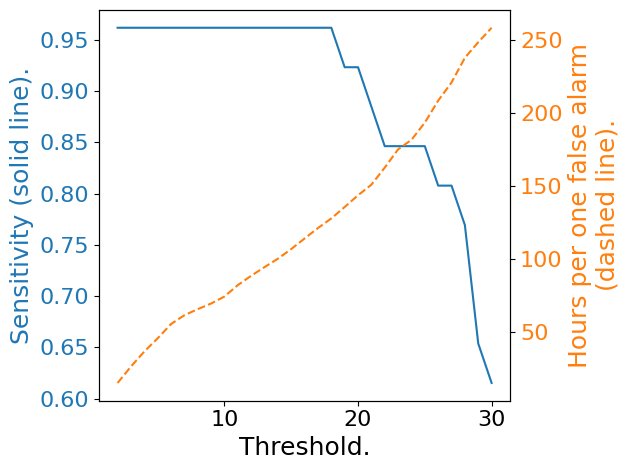

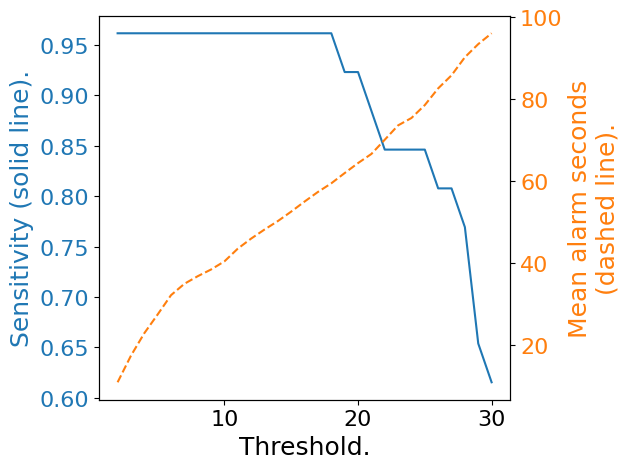

In [17]:
def plot_metrics(x, y1, y2, x_label, y1_label, y2_label, start_threshold, end_threshold, save_title):
    fontsize = 18
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel(x_label, fontsize=fontsize)
    ax1.tick_params(axis='x', labelsize=fontsize-2) 
    ax1.set_ylabel(y1_label, color=color, fontsize=fontsize)
    ax1.plot(x[start_threshold:end_threshold], y1[start_threshold:end_threshold], color=color, label=y1_label)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=fontsize-2)
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel(y2_label, color=color, fontsize=fontsize)
    ax2.plot(x[start_threshold:end_threshold], y2[start_threshold:end_threshold], color=color, label=y2_label, linestyle='dashed')
    ax2.tick_params(axis='y', labelcolor=color, labelsize=fontsize-2)
    fig.tight_layout()
    plt.savefig(save_title, dpi = 400, bbox_inches="tight")
    plt.show()
    plt.close()

start_threshold = 1
end_threshold = 30
plot_metrics(thresholds, sensitivity_list, false_alarm_rate_list,
             'Threshold.', 'Sensitivity (solid line).', 'Num. of false alarms per day\n(dashed line).',
             start_threshold, end_threshold, 'sensitivity-far.png')

plot_metrics(thresholds, sensitivity_list, hours_per_false_alarm_list,
             'Threshold.', 'Sensitivity (solid line).', 'Hours per one false alarm\n(dashed line).',
             start_threshold, end_threshold, 'sensitivity-hpfa.png')

plot_metrics(thresholds, sensitivity_list, mean_alarm_length_list,
             'Threshold.', 'Sensitivity (solid line).', 'Mean alarm seconds\n(dashed line).',
             start_threshold, end_threshold, 'sensitivity-mal.png')

# How the false prediction occurs

Number of walkings: 172996
Number of falling while walking: 26
Days of falling while walking: {128, 135, 1545, 910, 2067, 1687, 2338, 2860, 2481, 434, 1722, 2876, 3141, 2759, 464, 1490, 1107, 1495, 2139, 990, 2910, 3046, 2922, 2802, 3193, 2301}
8
15


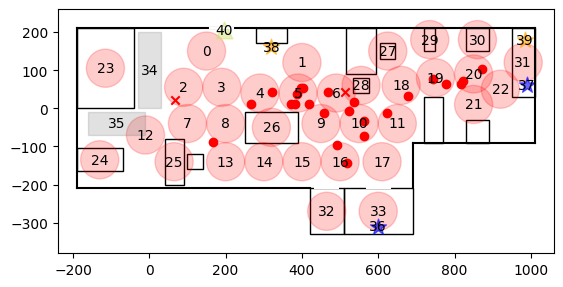

fall_length:[19, 22, 24, 27, 28, 28, 29, 29, 30, 31, 33, 35, 35, 35, 35, 35, 35, 36, 36, 36, 37, 38, 39, 39, 39, 40]


In [9]:
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_dt_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_dt_long")
# Plot fall places
layout_path = layout_database_path / "test_layout"
WT = utils.pickle_load(test_path, "WT")
sensors = utils.pickle_load(test_path, "SD_model")
true_regions = analysis.find_true_regions_in_ndarray(y_test_dt_long)
fall_w_points = []
fall_w_days = set()
fall_detection_rate = []
fall_num = 0
fall_wt = []
fall_index_in_WT= []

pred_intervals = analysis.seq2interval(y_pred_dt_long)
pred_intervals = [x for x in pred_intervals if x[1] - x[0] >= 18]
y_pred_dt_long = np.zeros_like(y_pred_dt_long)
for start, end in pred_intervals:
    y_pred_dt_long[start:end] = True

for i, wt in enumerate(WT):
    if wt.fall_w:
        fall_index_in_WT.append(i)
        fall_wt.append(wt)
        fall_w_points.append(wt.centers[wt.fall_w_index])
        fall_w_days.add(wt.timestamp[0].days)
        r = true_regions[fall_num]
        fall_detection_rate.append(np.sum(y_pred_dt_long[r[0]:r[1]]) / (r[1]-r[0]))
        fall_num += 1
print(f"Number of walkings: {len(WT)}")
print(f"Number of falling while walking: {len(fall_w_points)}")
print(f"Days of falling while walking: {fall_w_days}")
success_points = []
miss_points = []
for i, (p, r) in enumerate(zip(fall_w_points, fall_detection_rate)):
    if r > 0:
        success_points.append(p)
    else:
        miss_points.append(p)
        print(i)
ax = utils.save_layout(test_path, layout_path, sensors=sensors,WT=[],
    show=False, color_map_name="Blues", filename="fall_points",dpi=400,return_ax=True, with_name_furniture_place=False)
ax.scatter([p[0] for p in success_points], [p[1] for p in success_points], marker="o", color="red")
ax.scatter([p[0] for p in miss_points], [p[1] for p in miss_points], marker="x", color="red")
# plt.savefig(test_path / "experiment" / "fall_DT_3", dpi = 400, bbox_inches="tight")
plt.show()

fall_length = [r[1] - r[0] for r in true_regions]
print(f"fall_length:{sorted(fall_length)}")

In [11]:
fall_index = 8
fall_start, fall_end = true_regions[fall_index]
print(fall_start, fall_end)
print(fall_end - fall_start)
print(timedelta(seconds = int(fall_start)), timedelta(seconds = int(fall_end)))
print(fall_w_points[fall_index])
print(fall_wt[fall_index])
print(fall_index_in_WT[fall_index])

129225046 129225081
35
1495 days, 15:50:46 1495 days, 15:51:21
(512.5, 42.5)
<WalkingTrajectory> type: Direct from Sofa (1495 days, 15:50:42.071428) to Dinner_Table_Chair (1495 days, 15:51:20.030180)
79046


In [12]:
AS = utils.pickle_load(test_path, "AS")
print(AS[fall_index_in_WT[fall_index]])
print(AS[fall_index_in_WT[fall_index]+1])

<ActivityDataPoint> <Activity>Watch TV from 1495 days, 15:01:57.020010 to 1495 days, 15:51:20.030180 at Sofa
<ActivityDataPoint> <Activity>Take a snack from 1495 days, 15:51:20.030180 to 1495 days, 16:03:12.974903 at Dinner_Table_Chair


In [15]:
start = 129225046
end = 129225081
# start = 202078165
# end = 202078195
width = 60*60*24

path = layout_database_path / "test_layout" / "test_data_5"
SD_model = utils.pickle_load(path, "SD_model")
SD = utils.pickle_load(path / "experiment", f"SD_mat_raw_1")
SD_names = utils.pickle_load(path / "experiment", "SD_names")

# extract motion sensor data
motion_sensor_indexes = []
for i, s_i in enumerate(SD_names):
    if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):
        motion_sensor_indexes.append(i)
SD = SD[start - width: end + width, motion_sensor_indexes]

# extract features of non response time
X = fall_feature_sliding(SD, time_step=1, window_len=5, nrt_type="max")
print(X.shape)

Extract fall features. 172834 / 172834. Completed!
(172835, 36)


In [16]:
test_path = layout_database_path / "test_layout" / "test_data_5"
decision_tree = utils.pickle_load(test_path / "experiment", "decision_tree")
# analysis.print_positive_path(decision_tree)
analysis.print_decision_path(decision_tree, X[width:width + end - start])

Sample 0: (X[0](0.00) <= 2.50) and (X[1](0.00) <= 0.50) and (X[3](0.00) <= 1.50) and (X[4](0.00) <= 0.50) and (2.50 < X[5](3.00) <= 3.50) and (X[6](0.00) <= 0.50) and (X[7](0.00) <= 3.50) and (X[8](0.00) <= 0.50) and (X[9](0.00) <= 0.50) and (X[10](0.00) <= 3.50) and (X[12](0.00) <= 3.50) and (X[13](0.00) <= 1.50) and (X[14](0.00) <= 3.50) and (X[15](0.00) <= 0.50) and (X[17](0.00) <= 0.50) and (X[18](0.00) <= 1.50) and (X[19](0.00) <= 0.50) and (X[21](0.00) <= 3.50) and (X[25](0.00) <= 0.50) and (0.50 < X[27](4.00)) and (X[33](0.00) <= 3.50) and (X[34](0.00) <= 3.50), predict False
Sample 1: (X[0](0.00) <= 2.50) and (X[1](0.00) <= 0.50) and (X[3](0.00) <= 1.50) and (X[4](0.00) <= 0.50) and (2.50 < X[5](3.00) <= 3.50) and (X[6](0.00) <= 0.50) and (X[7](0.00) <= 3.50) and (X[8](0.00) <= 0.50) and (X[9](0.00) <= 0.50) and (X[10](0.00) <= 3.50) and (X[12](0.00) <= 3.50) and (X[13](0.00) <= 1.50) and (X[14](0.00) <= 3.50) and (X[15](0.00) <= 0.50) and (X[17](0.00) <= 0.50) and (X[18](0.00)

In [7]:
analysis.print_positive_path(decision_tree)

(X[0] <= 2.5) and (X[1] <= 0.50) and (X[3] <= 0.5) and (X[4] <= 0.5) and (X[5] <= 2.5) and (X[6] <= 0.5) and (X[7] <= 3.50) and (X[8] <= 0.5) and (X[9] <= 0.5) and (X[10] <= 3.50) and (X[12] <= 0.5) and (X[13] <= 1.5) and (X[14] <= 1.5) and (X[15] <= 0.5) and (X[16] <= 25.50) and (X[17] <= 0.5) and (X[18] <= 1.5) and (X[19] <= 0.5) and (X[21] <= 1.5) and (716.50 < X[26]) and (1.50 < X[28]) and (X[33] <= 2.5) and (X[34] <= 1.5)
(X[0] <= 4.50) and (X[1] <= 0.50) and (X[3] <= 1.5) and (X[4] <= 3.50) and (X[5] <= 3.50) and (X[6] <= 0.5) and (X[7] <= 3.50) and (X[8] <= 0.5) and (X[9] <= 0.5) and (X[10] <= 3.50) and (X[12] <= 3.50) and (X[13] <= 1.5) and (X[14] <= 3.50) and (X[15] <= 3.5) and (X[17] <= 3.50) and (X[18] <= 1.5) and (2.5 < X[19] <= 3.5) and (1.50 < X[20]) and (1.5 < X[21] <= 3.5) and (X[29] <= 1.50) and (X[30] <= 2374.50) and (X[33] <= 3.50) and (X[34] <= 3.50)
(X[0] <= 4.50) and (X[1] <= 0.50) and (X[3] <= 1.5) and (X[4] <= 3.50) and (X[5] <= 3.50) and (X[6] <= 0.5) and (X[7]

In [30]:
import matplotlib.pyplot as plt

test_path = layout_database_path / "test_layout" / "test_data_5"
y_test_dt_long = utils.pickle_load(test_path / "experiment", "y_test_rule5_long")
y_pred_dt_long = utils.pickle_load(test_path / "experiment", "y_pred_rule5_long")
# Plot fall places
layout_path = layout_database_path / "test_layout"
WT = utils.pickle_load(test_path, "WT")
sensors = utils.pickle_load(test_path, "SD_model")
true_regions = analysis.find_true_regions_in_ndarray(y_test_dt_long)
fall_w_points = []
fall_w_days = set()
fall_detection_rate = []
fall_num = 0

true_intervals = analysis.seq2interval(y_test_dt_long)
pred_intervals = analysis.seq2interval(y_pred_dt_long)
pred_intervals = [x for x in pred_intervals if x[1] - x[0] >= 18]
false_indexes = []

for i, (pred_start, pred_end) in enumerate(pred_intervals):
    overlap = False
    for true_start, true_end in true_intervals:
        if pred_start <= true_end and true_start <= pred_end:
            overlap = True
            break
    if not overlap:
        false_indexes.append(i)
print(false_indexes)
print(len(false_indexes))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 22

In [31]:
path = layout_database_path / "test_layout" / "test_data_5"
SD_model = utils.pickle_load(path, "SD_model")
SD = utils.pickle_load(path / "experiment", f"SD_mat_raw_1")
SD_names = utils.pickle_load(path / "experiment", "SD_names")

# extract motion sensor data
motion_sensor_indexes = []
for i, s_i in enumerate(SD_names):
    if (SD_model[s_i].type_name in ['PIR', 'pressure', 'door']) and (i != 6):
        motion_sensor_indexes.append(i)
SD = SD[:, motion_sensor_indexes]
decision_tree = utils.pickle_load(test_path / "experiment", "decision_tree")

In [32]:
# analysis.print_positive_path(decision_tree)
index = 0
r = pred_intervals[index]
start, end = r[0], r[1]
print(start, end)
width = 60 * 60 * 10
# extract features of non response time
X = fall_feature_sliding(SD[start - width: end + width], time_step=1, window_len=5, nrt_type="max")
analysis.print_decision_path(decision_tree, X[width:width + end - start + 20])

113336 113358
Extract fall features. 72021 / 72021. Completed!
Sample 0: (X[4](0.00) <= 3.50) and (X[6](0.00) <= 4.50) and (X[8](0.00) <= 3.50) and (X[9](0.00) <= 3.50) and (X[13](0.00) <= 3.50) and (X[14](0.00) <= 3.50) and (4.50 < X[15](7.00)) and (X[18](0.00) <= 3.50) and (X[21](0.00) <= 3.50) and (0.50 < X[31](4.00)), predict False
Sample 1: (X[4](0.00) <= 3.50) and (X[6](0.00) <= 4.50) and (X[8](0.00) <= 3.50) and (X[9](0.00) <= 3.50) and (X[13](0.00) <= 3.50) and (X[14](0.00) <= 3.50) and (4.50 < X[15](8.00)) and (X[18](0.00) <= 3.50) and (X[21](0.00) <= 3.50) and (0.50 < X[31](5.00)), predict False
Sample 2: (X[4](0.00) <= 3.50) and (X[6](0.00) <= 4.50) and (X[8](0.00) <= 3.50) and (X[9](0.00) <= 3.50) and (X[13](0.00) <= 3.50) and (X[14](0.00) <= 3.50) and (4.50 < X[15](9.00)) and (X[18](0.00) <= 3.50) and (X[21](0.00) <= 3.50) and (0.50 < X[31](6.00)), predict False
Sample 3: (X[4](0.00) <= 3.50) and (X[6](0.00) <= 4.50) and (X[8](0.00) <= 3.50) and (X[9](0.00) <= 3.50) and (X

In [34]:
AS = utils.pickle_load(test_path, "AS")
t = timedelta(seconds = int(r[0]))
print(t)
for i, act in enumerate(AS):
    if act.start <= t <= act.end:
        print(i)
        break
print(AS[i-1])
print(AS[i])

1 day, 7:28:56
57
<ActivityDataPoint> <Activity>Rest from 1 day, 7:25:52.367565 to 1 day, 7:28:55.226910 at Sofa
<ActivityDataPoint> <Activity>Urination from 1 day, 7:28:55.226910 to 1 day, 7:32:08.578282 at Toilet_Door


In [20]:
mean, std = 5, 5
mean2 = np.log(mean**2/np.sqrt(mean**2+std**2))
std2 = np.sqrt(np.log(1 + std**2/mean**2))
mean, std = mean2, std2
print(mean, std)

from scipy.stats import norm
x_value = 1
F_x = norm.cdf(-mean/std)
print(F_x)


1.2628643221541276 0.8325546111576977
0.06465169448402877


In [23]:
fall_days = [128, 135, 1545, 910, 2067, 1687, 2338, 2860, 2481, 434, 1722, 2876, 3141, 2759, 464, 1490, 1107, 1495, 2139, 990, 2910, 3046, 2922, 2802, 3193, 2301]
for i in range(9):
    start = i * 360
    end = (i+1) * 360
    num = len([d for d in fall_days if start <= d < end])
    print(f"{i} - {i+1}: {num}")

0 - 1: 2
1 - 2: 2
2 - 3: 2
3 - 4: 1
4 - 5: 5
5 - 6: 2
6 - 7: 3
7 - 8: 4
8 - 9: 5
